# Load and Perturbe Image

In [5]:
from __future__ import print_function, division
import cv2
import torch
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
results_dir = 'results/'
example_name = "toyexample_6"

In [6]:
%load_ext autoreload
%autoreload 2

from .model import sparse3DBA
from .helpers.utils import sobel_filter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
toy_pickle_path = "toy_example/data/%s_data.p" % example_name
toy_image_path = "toy_example/data/%s.png" % example_name

In [8]:
data = pickle.load(open(toy_pickle_path, 'rb'))
img = cv2.imread(toy_image_path)

In [45]:
#Create a 10° rotated (around z-axis) calibrated projection matrix (relative to identity)
T_perturbed = np.array([[math.cos(10*math.pi/180), -math.sin(10*math.pi/180), 0, 0],
             [math.sin(10*math.pi/180), math.cos(10*math.pi/180), 0, 0],
             [0, 0, 1, 0]])

In [15]:
data['coords'] = np.around(data['2d_points']).astype(int) - 1

In [16]:
data['K']

array([[ 50.,   0., 512.],
       [  0.,  50., 512.],
       [  0.,   0.,   1.]])

In [47]:
# Camera matrix
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]

In [48]:
# Round double coords to ints -> to use as index in matrix
coords_2d = np.around(projected_2d)
coords_2d = coords_2d.astype(int) - 1

In [49]:
# Draw perturbed points into original image
img = img.astype('uint8')
for i, p in enumerate(coords_2d):
    print(i, p)
    cv2.circle(img, tuple(p), 4, (128, 128, 0), -1)

0 [459 824]
1 [743 513]
2 [329 168]
3 [873 719]
4 [121 783]
5 [576 335]
6 [419  82]
7 [398 853]
8 [ -6 723]
9 [757 317]
10 [855 498]
11 [408 666]
12 [204 285]
13 [189 260]


True

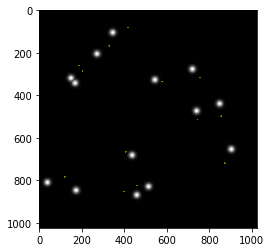

In [50]:
# Show image with perturbed points + Write
plt.imshow(img)
cv2.imwrite(results_dir + example_name + '_perturbed_points.png', img)

# Feature BA

In [59]:
from .model import optimizer_step, indexing_

from .helpers.utils import (from_homogeneous, to_homogeneous,
                batched_eye_like, skew_symmetric, so3exp_map)

from .helpers.utils import squared_loss, scaled_loss

from torch.nn.functional import interpolate

In [60]:
# Reload image as doubles
data = pickle.load(open(toy_pickle_path, 'rb'))
img = cv2.imread(toy_image_path,0)
img = img.astype('double')

In [61]:
# Create image tensor
img_torch = torch.from_numpy(img)[None,...]

# Convolve Sobel Filter to extract x and y gradient: 1xHxW
grad_x, grad_y = sobel_filter(img_torch)

In [62]:
%%capture
# Exemplary, Show perturbed points on the y-gradient of the image. Resized to 128x128
"""
grad_y_img = grad_y.numpy().reshape(img.shape).astype('uint8')
for i, p in enumerate(coords_2d):
    print(i, p)
    cv2.circle(grad_y_img, tuple(p), 1, (128, 128, 0), -1)
plt.imshow(grad_y_img)
cv2.imwrite(results_dir+example_name + "_grad_x.png", grad_x.numpy().reshape(img.shape).astype('uint8'))
cv2.imwrite(results_dir+example_name + "_grad_y.png", grad_y.numpy().reshape(img.shape).astype('uint8'))
"""

In [63]:
#Create a 10° rotated (around z-axis) calibrated projection matrix (relative to identity)

angle = 4

offset_x = 0
offset_y = 0
offset_z = -0.1
T_perturbed = np.array([[math.cos(angle*math.pi/180), -math.sin(angle*math.pi/180), 0,offset_x],
             [math.sin(angle*math.pi/180), math.cos(angle*math.pi/180), 0, offset_y],
             [0, 0, 1, offset_z]])
print(T_perturbed)

[[ 0.99756405 -0.06975647  0.          0.        ]
 [ 0.06975647  0.99756405  0.          0.        ]
 [ 0.          0.          1.         -0.1       ]]


In [64]:
data['coords'] = np.around(data['2d_points']).astype(int) - 1

In [65]:
# Camera matrix
P_perturbed = np.dot(data['K'], T_perturbed)

# Project 3D points with this new perturbed camera matrix: np.array Nx2
projected_2d = np.dot(P_perturbed, np.concatenate((data['3d_points'], np.ones(len(data['3d_points']))[:, None]),-1).T)
projected_2d = (projected_2d.T/projected_2d.T[:,2,None])[:, :2]

In [82]:
# Define image size
im_height, im_width = img.shape
# Load 3D Points
pts3D = torch.from_numpy(data['3d_points'][:,:3])
# Load 2D Points in reference image: [[x1,y1], ....]
ref2d = torch.from_numpy(np.flip(data['coords'], axis = 1).copy())
# 2D Tensor with intensity at reference feature pixel (= center of gaussian = 255)-> [[255],[255], ...] NFx1
feature_ref = torch.cat([img_torch[:, i, j].unsqueeze(0) for i, j in zip(ref2d[:,0], ref2d[:,1])]).type(torch.DoubleTensor)
feature_map_query = img_torch.type(torch.DoubleTensor)

#Load initial rotation and translation for query image (=perturbed image)
R_init, t_init = torch.from_numpy(T_perturbed[:, :3]), torch.from_numpy(T_perturbed[:, 3])
feature_grad_x = grad_x
feature_grad_y = grad_y

# Camera intrinsics tensor 3x3
K = torch.from_numpy(data['K'])


hypercolumn_size = (128,128)
#Test: Downsample feature by 8x8 using bilinear
feature_map_query = interpolate(feature_map_query.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0) #interpolate needs 4D tensor, I add batch dimension
feature_grad_x = interpolate(feature_grad_x.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0)
feature_grad_y = interpolate(feature_grad_y.unsqueeze(0), size=hypercolumn_size,
                                    mode = 'bilinear').squeeze(0)

feature_map_query.shape

torch.Size([1, 128, 128])

In [75]:
# Set runtime parameters
n_iters = 50
lambda_ = 0.01 # regularization
verbose=False

In [76]:
# Load actual model
model = sparse3DBA(n_iters = n_iters, lambda_ = lambda_, verbose=verbose)

In [77]:
# Run the model -> this calls the forward method of model
R, t = model(pts3D, feature_ref, feature_map_query, feature_grad_x, feature_grad_y, K, im_width, im_height, R_init=R_init, \
             t_init= t_init, track = True)

cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration
cost increased, continue with next iteration


In [78]:
cost_list = model.track_["costs"]
point_list = torch.stack(model.track_["points2d"])
R_list = model.track_["Rs"]
t_list = model.track_["ts"]

# Visualization

In [79]:
import visualization.plot_3d_tools as plot_3d

In [80]:
# get final cost to see if visualization makes sense (Should be really low)
print(cost_list[0])
print(cost_list[-1])
print(R)
print(t)

27497.41105769231
276.125
tensor([[ 9.9999e-01, -4.3819e-03,  5.5901e-04],
        [ 4.3822e-03,  9.9999e-01, -4.2733e-04],
        [-5.5713e-04,  4.2977e-04,  1.0000e+00]], dtype=torch.float64)
tensor([-0.0401, -0.0690, -0.0245], dtype=torch.float64)


In [195]:
%%capture
# Create a list of images, size Hx2*W
# Takes some time (~ half a minute with n_iters=100 and image size 1024x1024)
# Change DPI and draw parameters(radius, thickness) as you like
my_dpi = 160 #For plotting, change this as you like, 160 works good for 1024x1024

# Create base-image im RGB
rgb_img = cv2.cvtColor(img.astype('uint8').copy(),cv2.COLOR_GRAY2RGB)
height, width, layers = rgb_img.shape

# Set of 2D points: n_iters+1 x N x 2
pts = np.array(point_list,dtype=np.int32)
img_list=[]
for i in range(n_iters +1):
    # Create a copy of base image to work on
    img_int = rgb_img.copy()
    
    label = "Cost: %f" % cost_list[i]
    
    # Create cost plot (you can add any measure vs. iteration you like here, e.g. the error of a specific feature)
    fig, ax= plt.subplots(1,1,figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
    ax.plot(range(i+1),np.array(cost_list[:i+1]), color = "red")
    ax.set_xlim([0,n_iters+1])
    ax.set_title("Cost vs. Iterations")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Cost (mean)")
    ax.set_ylim([0,max(cost_list)*1.1])
    # Convert image to an array so we can concatenate with our image
    fig_data = plot_3d.fig2data(fig)
    
    # For every 2D point in our image
    for j, p in enumerate(coords_2d):
        # Draw past line
        cv2.polylines(img_int, np.int32([pts[:i+1,j,:]]), False, (0,0,255), 1)
        # Draw start point
        cv2.circle(img_int, tuple(pts[0,j,:]), 4, (0,255,0), -1) 
        # Draw current point
        cv2.circle(img_int, tuple(pts[i,j,:]), 4, (0,0,255), -1) 
        # Draw Label
        cv2.putText(img_int, label, (20,20), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 2)
    
    # Append image list
    img_list.append(np.concatenate((img_int,fig_data), axis=1))

In [206]:
# Create video out of image list
height, width, layers = img_list[0].shape
#framerate (frames/second)
fr = 2
video= cv2.VideoWriter(results_dir + example_name + "_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 2, (width,height))
for image in img_list:
    video.write(image)
video.release()

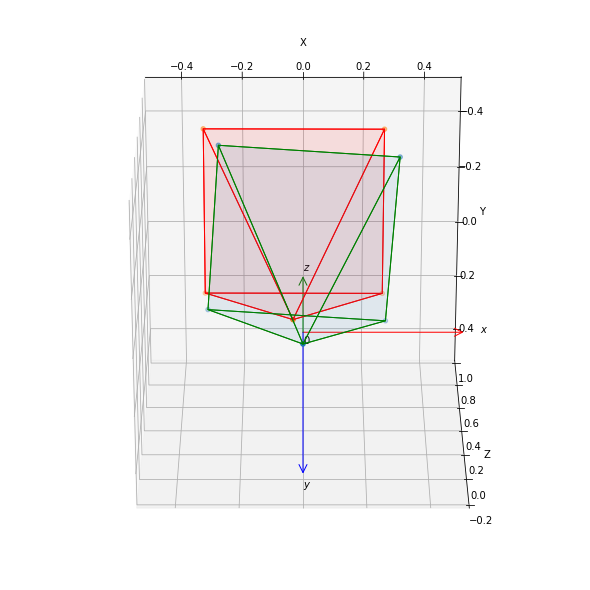

In [163]:
# Visualize camera pose  in 3D (example)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Draw Coordinate frame
plot_3d.plot_coordinate_system(ax, size = (0.5,0.5,0.5))

# Plot initial camera pose (green pyramid)
plot_3d.plot_camera(ax,R_init.numpy(),t_init.numpy(), edgecolor="g", facecolor=None, alph=0.05)

# Plot final camera pose (red pyramid)
plot_3d.plot_camera(ax,R.numpy(),t.numpy(), edgecolor="r", facecolor="r", alph=0.05)

# Adjust Angle of 3D plot view
ax.view_init(elev=-65, azim=-90)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_zlim(-0.2, 1)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# ToDo: Scatter the 3D points in this plot

# Show Plot
plt.show()

In [205]:
%%capture
# Create a list of images, size (H+cost_plot_height)x2*W
# Takes some time (~ half a minute with n_iters=100 and image size 1024x1024)
# Change DPI and draw parameters(radius, thickness) as you like
my_dpi = 160 #For plotting, change this as you like, 160 works good for 1024x1024

# Create base-image im RGB
rgb_img = cv2.cvtColor(img.astype('uint8').copy(),cv2.COLOR_GRAY2RGB)
height, width, layers = rgb_img.shape
 
cost_plot_height = 300

# Set of 2D points: n_iters+1 x N x 2
pts = np.array(point_list,dtype=np.int32)
img_list=[]
for i in range(n_iters+1):
    # Create a copy of base image to work on
    img_int = rgb_img.copy()
    
    label = "Cost: %f" % cost_list[i]
    
    # Create cost plot (top, you can add any measure vs. iteration you like here, e.g. the error of a specific feature)
    fig, ax= plt.subplots(1,1,figsize=(width*2/my_dpi, cost_plot_height/my_dpi), dpi=my_dpi)
    ax.plot(range(i+1),np.array(cost_list[:i+1]), color = "red")
    ax.set_xlim([0,n_iters+1])
    ax.set_title("Cost vs. Iterations")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Cost (mean)")
    ax.set_ylim([0,max(cost_list)*1.1])
    cost_fig_data = plot_3d.fig2data(fig)
    plt.tight_layout()
    
    
    # Visualize camera pose  in 3D (example) (right)
    fig = plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
    ax = fig.add_subplot(111, projection='3d')
    # Draw Coordinate frame
    plot_3d.plot_coordinate_system(ax, size = (0.5,0.5,0.5))
    # Plot initial camera pose (green pyramid)
    # Swap to R_init, t_init if you want initial pose
    plot_3d.plot_camera(ax,R.numpy(),t.numpy(), edgecolor="g", facecolor=None, alph=0.05) 
    # Plot final camera pose (red pyramid)
    plot_3d.plot_camera(ax,R_list[i].numpy(),t_list[i].numpy(), edgecolor="r", facecolor="r", alph=0.05)
    # Adjust Angle of 3D plot view
    ax.view_init(elev=-65, azim=-90)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-0.2, 1)
    #Remove Whitespace
    fig.subplots_adjust(left=-0.2, right=1.2, bottom=0, top=1)
    # Convert image to an array so we can concatenate with our image
    fig_data = plot_3d.fig2data(fig)
    
    # For every 2D point in our image (left)
    for j, p in enumerate(coords_2d):
        # Draw past line
        cv2.polylines(img_int, np.int32([pts[:i+1,j,:]]), False, (0,0,255), 1)
        # Draw start point
        cv2.circle(img_int, tuple(pts[0,j,:]), 4, (0,255,0), -1) 
        # Draw current point
        cv2.circle(img_int, tuple(pts[i,j,:]), 4, (0,0,255), -1) 
        # Draw Label
        cv2.putText(img_int, label, (20,20), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 2)
    
    # Append image list
    lower_ims = np.concatenate((img_int,fig_data), axis=1)
    print(lower_ims.shape)
    img_list.append(np.concatenate((cost_fig_data,lower_ims), axis=0))

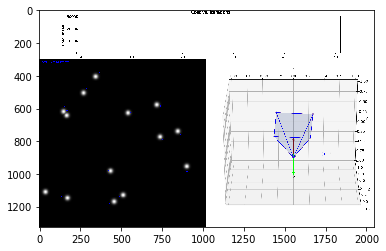

In [201]:
plt.imshow(img_list[0])

In [ ]:
new_proj_1[mask,:]
